# Project 3

- **Dataset(s) to be used:**
- [World GDP Growth](https://www.kaggle.com/datasets/sazidthe1/world-gdp-growth)
- [Fertility Rate by Counntry](https://www.kaggle.com/datasets/elmoallistair/fertility-rate-19602020/data)
- **Analysis question:** Some scholars have argued that fertility does not exhibit a strong positive correlation with economic growth in a country. This project aims to validate their claim.
- **Columns that will (likely) be used:**
  - [Fertility Rate]
  - [GDO Growth]
  - [Year](Before melting)
- **Hypothesis**: [Fertility does not exhibit a strong positive correlation with economic growth]
- **Site URL:** [URL from Publish section]

## Step 1: Clean
### Strip space, remove column name errors (some unusual characters).
### Use melt to ensure that fertiliti rate and gdp growth are value that we are going to study

In [22]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.io as pio

pio.renderers.default = "vscode+jupyterlab+notebook_connected"
fertility_data = pd.read_csv("fertility_rate.csv", encoding="latin1")
gdp_data = pd.read_csv("world_gdp_data.csv", encoding="latin1")
fertility_data.columns = fertility_data.columns.str.strip().str.replace("ï»¿", "")
gdp_data.columns = gdp_data.columns.str.strip()

# Filter out irrelevant columns
fertility_data = fertility_data.loc[:, fertility_data.columns.str.startswith("Country") | fertility_data.columns.str.match(r'^(19[89]\d|20[0-2]\d)$')]
gdp_data = gdp_data.loc[:, gdp_data.columns.str.contains("country|indicator", case=False) | gdp_data.columns.str.match(r'^(19[89]\d|20[0-2]\d)$')]

fertility_data = fertility_data.melt(id_vars=[fertility_data.columns[0]], var_name="Year", value_name="Fertility Rate")
fertility_data.rename(columns={fertility_data.columns[0]: "Country"}, inplace=True)
gdp_data = gdp_data.melt(id_vars=["country_name"], var_name="Year", value_name="GDP Growth")

gdp_data

,country_name,Year,GDP Growth
0,Afghanistan,indicator_name,Annual GDP growth (percent change)
1,Albania,indicator_name,Annual GDP growth (percent change)
2,Algeria,indicator_name,Annual GDP growth (percent change)
3,Andorra,indicator_name,Annual GDP growth (percent change)
4,Angola,indicator_name,Annual GDP growth (percent change)
...,...,...,...
9011,Vietnam,2024,5.8
9012,West Bank and Gaza,2024,2.7
9013,Yemen,2024,2.0
9014,Zambia,2024,4.3


## Step 2: Merge
### Merge two data set on country and years, ensure that gdp growth rate of a country in a perticular year is matched with 
### it's fertility rate of that year, convert columns to numeric format

In [20]:
merged_data = pd.merge(fertility_data, gdp_data, left_on=["Country", "Year"], right_on=["country_name", "Year"], how="inner")
merged_data = merged_data.drop(columns=["country_name"])

merged_data["Fertility Rate"] = pd.to_numeric(merged_data["Fertility Rate"], errors="coerce")
merged_data["GDP Growth"] = pd.to_numeric(merged_data["GDP Growth"], errors="coerce")

# Since GDP growth rarely fall out side of +-10%, I exluded outliers for better plotting
filtered_data = merged_data[(merged_data["GDP Growth"] >= -10) & (merged_data["GDP Growth"] <= 10)].dropna()
# OLS line
X = sm.add_constant(filtered_data["Fertility Rate"])
model = sm.OLS(filtered_data["GDP Growth"], X).fit()
filtered_data["OLS Line"] = model.predict(X)

filtered_data

,Country,Year,Fertility Rate,GDP Growth,OLS Line
1,Albania,1980,3.62,2.7,2.974443
2,Algeria,1980,6.79,-5.4,3.168829
3,Angola,1980,7.46,2.4,3.209914
4,Antigua and Barbuda,1980,2.12,8.2,2.882463
5,Argentina,1980,3.30,0.7,2.954821
...,...,...,...,...,...
6718,Vanuatu,2020,3.71,-5.0,2.979962
6720,Vietnam,2020,2.05,2.9,2.878170
6721,Yemen,2020,3.61,-8.5,2.973830
6722,Zambia,2020,4.50,-2.8,3.028405


## Step 3: Plot: plot scatter graph and add a OLS line

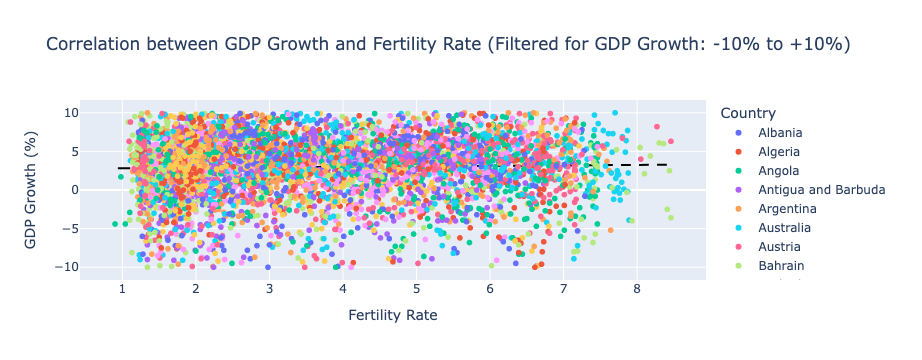

In [15]:
fig = px.scatter(
    filtered_data,
    x="Fertility Rate",
    y="GDP Growth",
    color="Country",
    title="Correlation between GDP Growth and Fertility Rate (Filtered for GDP Growth: -10% to +10%)",
    labels={"Fertility Rate": "Fertility Rate", "GDP Growth": "GDP Growth (%)"},
    hover_data=["Country", "Year"]
)

fig.add_scatter(
    x=filtered_data["Fertility Rate"],
    y=filtered_data["OLS Line"],
    mode="lines",
    name="OLS Line",
    line=dict(color="black", dash="dash")
)

fig.show()

## Step 4: correlation coefficient
#### Can not observe a clear correlation. I then manually calculated correlation coefficient between fertility rate and gdp growth.

In [16]:
correlation = filtered_data["Fertility Rate"].corr(filtered_data["GDP Growth"])
print(f"Correlation Coefficient: {correlation}")

Correlation Coefficient: 0.029974808406522176


### Conclusion: there is not a strong linear correlation (coefficient = 0.0299) between GDP growth and fertility rate. There are many possible explainations:
#### 1. A high fertility rate often leads to a larger proportion of dependents (children and elderly) relative to the working-age population.
#### 2. Economic growth is more linked to labor productivity, innovation, and technology rather than sheer population size.
#### 3. Developing Countries with over population problems might experience society turmoils more frequent than those with steady population growth, over population might also lead to administrative obstacles due to ominipresent poverty.
#### 4. There might be a inverse casuality problem, tools like STATA might help studying this issue. 
#### 5. Overburdened infrastructure, limited access to education, and resource depletion can hinder economic growth.